In [5]:
import os
import sys
from KSPSolvers import *
from numpy import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from pylab import *
%matplotlib inline

# 2D - Heat Equation. 
This is a forward Euler Solver for a 2D heat equation. 
$$  \frac{\partial u}{\partial t} - c \Delta u = f, \;\; \text{ on } \; \Omega = [x_0, x_{End}],[y_0, y_{End}]  $$ 
Goal here is to use diriclet known boundary conditions. 

In [65]:
def pmod(i,n):
    value = i%n
    if value < 0:
        value = n + value
    return value;

def utrue(x,y,t):
    return sin(3.0*x)*cos(.5*y)*exp(-t)

def forcing(x,y,t,c):
    return 9.25*c*cos(0.5*x)*exp(-t)*sin(3.0*y) - cos(0.5*x)*exp(-t)*sin(3.0*y)

In [66]:
def WorldToCode(i,j,grdcellsx,grdcellsy):
    return grdcellsx*pmod(j,grdcellsy) + pmod(i,grdcellsx);
    
def CodeToWorld(k,grdcellsx,grdcellsy):
    i = int(k%grdcellsx); 
    j = int(k/grdcellsy);
    return i,j;  
    
def WorldToCodeVector(V,grdcellsx,grdcellsy):
    v       = zeros(grdcellsx*grdcellsy,float);
    v.shape = (grdcellsx*grdcellsy,1);

    for j in range(grdcellsy):
        for i in range(grdcellsx):
            cdi = WorldToCode(i,j,grdcellsx,grdcellsy);
            v[cdi] = V[i,j];
    return v;

def CodeToWorldVector(u, grdcellsx,grdcellsy):     
    U       = zeros(grdcellsx*grdcellsy,float);           
    U.shape = (grdcellsx,grdcellsy);
    for k in range(grdcellsx*grdcellsy):
        i,j = CodeToWorld(k,grdcellsx,grdcellsy);
        U[i,j] = u[k]; 
    return U; 

In [67]:
def Plot(U,X,Y,t):
    # Plot the a solution as a wireframe. 
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    p = ax.plot_wireframe(X,Y,U, rstride=1,cstride=1)
    strTitle = "Wire Frame Plot of u(x,y," + str(t) + ")"; 
    fig.suptitle(strTitle)
    plt.xlabel("$x$-axis")
    plt.ylabel("$y$-axis")
    plt.show()


def ComputeTimeStepError(U,t,x0,xEnd,y0,yEnd,grdcellsx,grdcellsy):
    # ==========================================================================*/
    # Loop over the cell centers and calculate the Integration of a function    */
    # ==========================================================================*/
    IntLocalGrid = 0.0;
    hx = ((xEnd - x0)/grdcellsx);
    hy = ((yEnd - y0)/grdcellsy);
    for j in range(grdcellsy):
        ypt = y0 + (0.5 + j)*hy;
        for i in range(grdcellsx):
            xpt = x0 + (0.5 + i)*hx;
            # ==================================================================*/
            # Get the approximated solution over the given cell                 */
            # ==================================================================*/
            IntCell = ((U[i,j] - utrue(xpt,ypt,t))**2.0)*(hx*hy);
            IntLocalGrid = IntLocalGrid + IntCell;
    return IntLocalGrid;


def ComputeTimeStepError2(U,t,x0,xEnd,y0,yEnd,grdcellsx,grdcellsy):
    # ==========================================================================*/
    # Set the quad points and weights for the 5 point quadrature rule on [-1,1] */
    # ==========================================================================*/
    quadpt       = zeros(5,float);
    quadpt.shape = (5,1);
    quadwt       = zeros(5,float);
    quadwt.shape = (5,1);
    
    quadpt[0] = -(1.0/3.0)*((5.0 + 2.0*((10.0/7.0)**0.5))**0.5);
    quadpt[1] = -(1.0/3.0)*((5.0 - 2.0*((10.0/7.0)**0.5))**0.5);
    quadpt[2] =  0.0;
    quadpt[3] =  (1.0/3.0)*((5.0 - 2.0*((10.0/7.0)**0.5))**0.5);
    quadpt[4] =  (1.0/3.0)*((5.0 + 2.0*((10.0/7.0)**0.5))**0.5);

    quadwt[0] = (322.0 - 13.0*((70.0)**0.5))/900.0;
    quadwt[1] = (322.0 + 13.0*((70.0)**0.5))/900.0;
    quadwt[2] = (128.0/225.0);
    quadwt[3] = (322.0 + 13.0*((70.0)**0.5))/900.0;
    quadwt[4] = (322.0 - 13.0*((70.0)**0.5))/900.0;

    
    # ==========================================================================*/
    # Loop over the cell centers and calculate the Integration of a function    */
    # ==========================================================================*/
    IntLocalGrid = 0.0;
    
    for j in range(grdcellsy):
        for i in range(grdcellsx):

            # ==================================================================*/
            # Get the approximated solution over the given cell                 */
            # ==================================================================*/
            Uh = 0.0; # U[i,j];
            
            # ==================================================================*/
            # Get cell corners: cxl, cxr, cyb, cyt assuming fully periodic Grid */
            # ==================================================================*/
            cxl  = x0 + (i  )*((xEnd - x0)/grdcellsx);
            cxr  = x0 + (i+1)*((xEnd - x0)/grdcellsx);
            cyt  = y0 + (j+1)*((yEnd - y0)/grdcellsy);
            cyb  = y0 + (j  )*((yEnd - y0)/grdcellsy);
            detJ = 0.25*(cxr-cxl)*(cyt-cyb);
            
            IntCell = 0.0;

            # This is a 25 point gaussian quadrature rule.
            for indx in range(5):
                xvalue = 0.5*((cxr-cxl)*quadpt[indx] + (cxl + cxr));
                for indy in range(5):
                    yvalue = 0.5*((cyt-cyb)*quadpt[indy] + (cyt + cyb));
                    IntCell = IntCell + ((utrue(xvalue,yvalue,t) - Uh )**2.0)*(quadwt[indx]*quadwt[indy]*detJ);
        
            IntLocalGrid = IntLocalGrid + IntCell;

    #print IntLocalGrid;
    return IntLocalGrid;

## EDIT CODE PARAMETERS BELOW

In [68]:
# Set up a grid to comput on:

grdcellsx = 16;    # Number of cells in domain x-direction
grdcellsy = 16;    # Number of cells in domain y-direction
TimeSteps = 16;  # Time steps the code will take.
PlotEvery = 4;   # Decide how often to print your work.
# Diffusion Coefficent "c": 
c = 0.5;

# Pick a Theta Value (0 --> Forward Euler, 1 --> Backward Euler, 0.5 is a Crank-Nicolson Method).
theta = 0.5;

# Set bounds on the computational domain (OMEGA). 
x0   = 0.0; 
y0   = 0.0; 
xEnd = 2.0*pi;
yEnd = 2.0*pi;

t0   = 0.0;
T    = 2.0;

# Derived Parameters

In [69]:
hx = (xEnd - x0)/(grdcellsx);
hy = (yEnd - y0)/(grdcellsy);

dt = (T-t0)/TimeSteps;
gamma = (c*dt)/(hx*hx); 

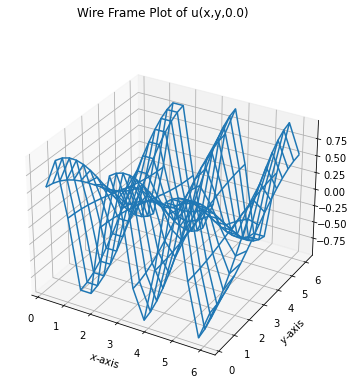

In [70]:
# Position of the Cell Centers.
x = zeros(grdcellsx, float);  x.shape=(grdcellsx,1);
y = zeros(grdcellsy, float);  y.shape=(grdcellsy,1);

if(hx != hy): 
    print("Warning !!!! Mesh spacings in x and y are different! ")

# Cell center positions (adjusted for boundarys).
x = linspace(x0+0.5*hx,xEnd-0.5*hx,grdcellsx);
y = linspace(y0+0.5*hy,yEnd-0.5*hy,grdcellsy);

# Grid of cell centers.
Y, X = meshgrid(x,y);

# Initial contition at time t0.
U0 = utrue(X,Y,t0);

# Plot the initial solution as a Wire Frame.
Plot(U0,X,Y,t0);

In [71]:
# Set up the Matrix System for Forward Euler. 
unknowns = grdcellsx*grdcellsy; 
Af   = zeros(unknowns*unknowns, float); Af.shape   = (unknowns,unknowns); 
Ab   = zeros(unknowns*unknowns, float); Ab.shape   = (unknowns,unknowns);
un   = zeros(unknowns,float);           un.shape   = (unknowns,1);
unpo = zeros(unknowns,float);           unpo.shape = (unknowns,1); 

# Populate the system matrix Af 
for j in range (1,grdcellsy-1):
    for i in range (1,grdcellsx-1):
        # set entry position. 
        ipo = (i+1)%grdcellsx; 
        jpo = (j+1)%grdcellsy; 
        imo = (i-1)%grdcellsx; 
        jmo = (j-1)%grdcellsy;
        
        cdi   = WorldToCode(i,j,grdcellsx,grdcellsy);
        cdj   = WorldToCode(i,j,grdcellsx,grdcellsy);
        cdipo = WorldToCode(ipo,j,grdcellsx,grdcellsy);
        cdimo = WorldToCode(imo,j,grdcellsx,grdcellsy);
        cdjpo = WorldToCode(i,jpo,grdcellsx,grdcellsy);
        cdjmo = WorldToCode(i,jmo,grdcellsx,grdcellsy);
        
        # Forward Euler Matrix.
        
        Af[cdi   ,   cdj   ] = 1.0 - (1.0-theta)*4.0*gamma
        Af[cdi   ,   cdipo ] = (1.0-theta)*4.0*gamma
        Af[cdi   ,   cdimo ] = (1.0-theta)*4.0*gamma
        Af[cdi   ,   cdjpo ] = (1.0-theta)*4.0*gamma
        Af[cdi   ,   cdjmo ] = (1.0-theta)*4.0*gamma
        
        # Backward Euler Matrix.
        
        Ab[cdi   ,   cdj   ] = 1.0+theta*4.0*gamma
        Ab[cdi   ,   cdipo ] = -theta*4.0*gamma
        Ab[cdi   ,   cdimo ] = -theta*4.0*gamma
        Ab[cdi   ,   cdjmo ] = -theta*4.0*gamma
        Ab[cdi   ,   cdjpo ] = -theta*4.0*gamma
        

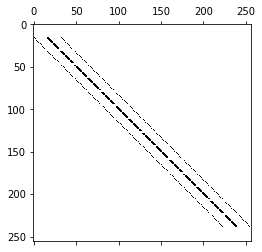

In [72]:
show(spy(Af))

In [73]:
# Adjust the vlaues of FN and FNPO on the boundary to represent the true solution.
""" Add Boundary Condition Loop. """

for j in range(0,grdcellsy,grdcellsy-1):
    for i in range(grdcellsx):
        
        cdi = WorldToCode(i,j,grdcellsx,grdcellsy)
        cdj = cdi
        
        Af[cdi,cdj] = 1.0
        Ab[cdi,cdj] = 1.0


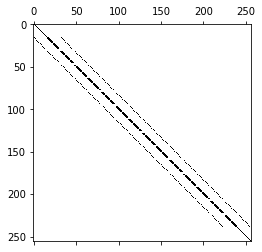

In [74]:
show(spy(Af))

In [75]:
for i in range(0,grdcellsx,grdcellsx-1):
    for j in range(1,grdcellsy-1):
        
        cdi = WorldToCode(i,j,grdcellsx,grdcellsy)
        cdj = cdi
        
        Af[cdi,cdj] = 1.0
        Ab[cdi,cdj] = 1.0

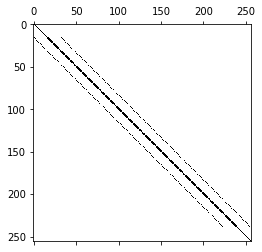

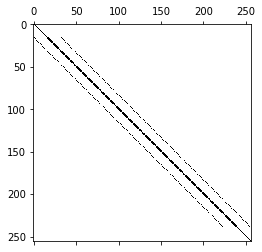

In [76]:
# added some spy plots for debuggin.
show(spy(Ab))
show(spy(Af))

# Time Loop: 

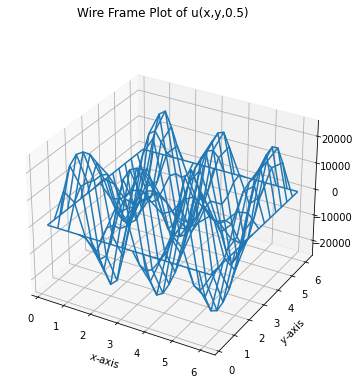

Error =  24771.550894055497
time  =  0.5


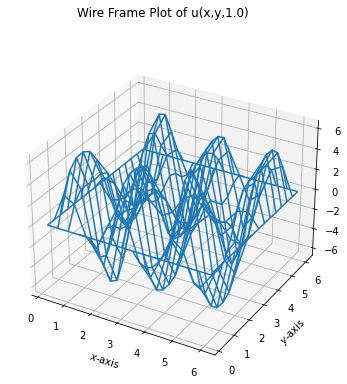

Error =  636150099.0686898
time  =  1.0


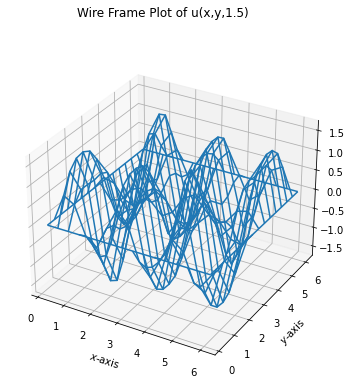

Error =  16393880528331.816
time  =  1.5


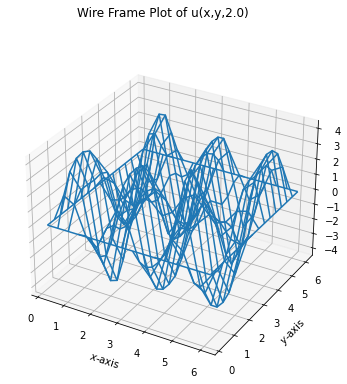

Error =  4.225115451044853e+17
time  =  2.0


In [77]:
# Map U(0) --> un;
un = WorldToCodeVector(U0,grdcellsx,grdcellsy);

# Initialize the computational error:
FullError = 0.0;

# Move forward in a loop for the time Steps. 
for k in range(TimeSteps):
    t = (k+1)*dt

    # Set a forcing function for our code.  
    FN   = forcing(X,Y,(t-dt),c);
    FNPO = forcing(X,Y,t,c);

    # Change the shape of our forcing function. 
    fn   = WorldToCodeVector(FN,grdcellsx,grdcellsy);
    fnpo = WorldToCodeVector(FNPO,grdcellsx,grdcellsy);
    
    # Advance the solution in time using a Forward Euler Technique.
    #print "Af.dot(un)", Af.dot(un);
    RHS = Af.dot(un) + dt*((1.0-theta)*fn + theta*fnpo);

    #Adjust the solution in time using a Forward Euler Tecnhique.
    RHS = Af.dot(un)+dt*((1.0-theta)*fn+theta*fnpo);
    
    # Adjust the RHS for the Boundary Conditions.
    for j in range(0,grdcellsy,grdcellsy-1):
        for i in range(grdcellsx):
            bound = WorldToCode(i,j,grdcellsx,grdcellsy)
            RHS[bound] = utrue(X[i,j],Y[i,j],t)
            
    for i in range(0,grdcellsx,grdcellsx-1):
        for j in range(1,grdcellsy-1):
            bound = WorldToCode(i,j,grdcellsx,grdcellsy)
            RHS[bound] = utrue(X[i,j],Y[i,j],t)
                
    # Solve Systems.
    System = gmres(Matrix=Ab, RHS=RHS, x=un, Tol=1e-14, maxIts=len(un))
    unpo, error, totalIters = System.solve();
    
    # Reshape the solution for error computation and plotting.
    UNPO = CodeToWorldVector(unpo, grdcellsx,grdcellsy);

    # Compute the error difference between a true solution and our approximations.
    StepError = ComputeTimeStepError(UNPO,t,x0,xEnd,y0,yEnd,grdcellsx,grdcellsy)*dt;
    FullError = FullError + StepError;

    # Look at the solution if desired. 
    if((k+1)%PlotEvery == 0):
        # Plot the solution. 
        Plot(UNPO,X,Y,t);
        # Report the Error.
        print("Error = ", FullError**0.5);
        print("time  = ", t);

    # Lag the found time for the next step. 
    un = unpo;